In [4]:
from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os
import gc
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import h5py
import scipy.io as sio
import warnings
from muon import atac as ac
import seaborn as sns

from os.path import join
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_h5(path):
    with h5py.File(path, 'r') as f:
        print(f['matrix'].keys())
        print(f['matrix']['features'].keys())

        barcodes = [_.decode('utf-8') for _ in f['matrix']['barcodes'][:]]
        data = f['matrix']['data'][:]
        indices = f['matrix']['indices'][:]
        indptr = f['matrix']['indptr'][:]
        shape = f['matrix']['shape'][:]

        feature_type = [_.decode('utf-8') for _ in f['matrix']['features']['feature_type'][:]]
        feature_id   = [_.decode('utf-8') for _ in f['matrix']['features']['id'][:]]
        feature_name = [_.decode('utf-8') for _ in f['matrix']['features']['name'][:]]
        feature_interval = [_.decode('utf-8') for _ in f['matrix']['features']['interval'][:]]


        X = sps.csc_matrix(
            (data, indices, indptr), 
            shape = shape
        ).tocsc().astype(np.float32).T.toarray()

        adata = sc.AnnData(X)
        adata.obs_names = barcodes
        adata.var_names = feature_id
        adata.var['type'] = feature_type
        adata.var['name'] = feature_name
        adata.var['interval'] = feature_interval
    return adata

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2


In [6]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'] = -1 * ad.obsm['spatial']
        ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]

def reorder(ad1, ad2):
    shared_barcodes = ad1.obs_names.intersection(ad2.obs_names)
    ad1 = ad1[shared_barcodes].copy()
    ad2 = ad2[shared_barcodes].copy()
    return ad1, ad2

def load_peak_expr(_dir):
    data = sio.mmread(join(_dir, 'data.mtx'))
    cname = pd.read_csv(join(_dir, 'barcode.csv'), index_col=0)['x'].to_list()
    feat = pd.read_csv(join(_dir, 'feat.csv'), index_col=0)['x'].to_list()
    ad = sc.AnnData(sps.csr_matrix(data.T))
    ad.obs_names = cname
    ad.var_names = feat
    return ad

In [7]:
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_embryo_rna+atac/'

df_mult_rna = pd.read_csv(join(data_dir, 'rna+atac/GSM6799937_ME13_50um_matrix_merge.tsv'), sep='\t')
df_mult_rna_spatial = pd.read_csv(join(data_dir, 'rna+atac/GSM6801813_ME13_50um_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_rna = sc.AnnData(df_mult_rna.T, obsm={'spatial': df_mult_rna_spatial.loc[df_mult_rna.columns, [2, 3]].values})
ad_mult_rna.layers['counts'] = ad_mult_rna.X.copy()

ad_mult_atac = load_peak_expr(join(data_dir, 'rna+atac/ME13_50_peak_data'))
df_mult_atac_spatial = pd.read_csv(join(data_dir, 'rna+atac/GSM6801813_ME13_50um_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_mult_atac.obsm['spatial'] = df_mult_atac_spatial.loc[ad_mult_atac.obs_names, [2, 3]].values

ad_mult_rna, ad_mult_atac = reorder(ad_mult_rna, ad_mult_atac)

ad_atac11 = load_peak_expr(join(data_dir, 'atac/ME11_peak_data'))
df_atac11_spatial = pd.read_csv(join(data_dir, 'atac/GSM5238385_ME11_50um_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_atac11.obsm['spatial'] = df_atac11_spatial.loc[ad_atac11.obs_names, [2, 3]].values

ad_atac13 = load_peak_expr(join(data_dir, 'atac/ME13_peak_data'))
df_atac13_spatial = pd.read_csv(join(data_dir, 'atac/GSM5238386_ME13_50um_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_atac13.obsm['spatial'] = df_atac13_spatial.loc[ad_atac13.obs_names, [2, 3]].values

ad_atac13_2 = load_peak_expr(join(data_dir, 'atac/ME13_2_peak_data'))
df_atac13_2_spatial = pd.read_csv(join(data_dir, 'atac/GSM5238387_ME13_50um_2_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_atac13_2.obsm['spatial'] = df_atac13_2_spatial.loc[ad_atac13_2.obs_names, [2, 3]].values

shared_peaks = ad_mult_atac.var_names.intersection(ad_atac11.var_names).to_list()
ad_mult_atac = ad_mult_atac[:, shared_peaks].copy()
ad_atac11 = ad_atac11[:, shared_peaks].copy()
ad_atac13 = ad_atac13[:, shared_peaks].copy()
ad_atac13_2 = ad_atac13_2[:, shared_peaks].copy()
assert (ad_mult_atac.var_names == ad_atac11.var_names).all()

flip_coords([ad_mult_rna, ad_mult_atac, ad_atac11, ad_atac13, ad_atac13_2])
ad_mult_rna.obs_names = [f'mult-{x}' for x in ad_mult_rna.obs_names]
ad_mult_atac.obs_names = [f'mult-{x}' for x in ad_mult_atac.obs_names]
ad_atac11.obs_names = [f'atac11-{x}' for x in ad_atac11.obs_names]
ad_atac13.obs_names = [f'atac13-{x}' for x in ad_atac13.obs_names]
ad_atac13_2.obs_names = [f'atac13_2-{x}' for x in ad_atac13_2.obs_names]

for ad in [ad_mult_rna, ad_mult_atac, ad_atac11, ad_atac13, ad_atac13_2]:
    ad.layers['counts'] = ad.X.copy()

ad_mult_rna.obs['src'] = ad_mult_atac.obs['src'] = ['mult']*ad_mult_rna.n_obs
ad_atac11.obs['src'] = ['atac11']*ad_atac11.n_obs
ad_atac13.obs['src'] = ['atac13']*ad_atac13.n_obs
ad_atac13_2.obs['src'] = ['atac13_2']*ad_atac13_2.n_obs

In [8]:
# ad_rna_all = sc.concat([ad_mult_rna, ad_rna])
ad_atac_all = sc.concat([ad_mult_atac, ad_atac11, ad_atac13, ad_atac13_2])

sc.pp.highly_variable_genes(ad_mult_rna, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_mult_rna.var.query('highly_variable').index.to_numpy()

In [9]:
# ac.pp.tfidf(ad_atac_all, scale_factor=1e4)
sc.pp.highly_variable_genes(ad_atac_all, flavor='seurat_v3', n_top_genes=100000, batch_key='src')
hvp_names = ad_atac_all.var.query('highly_variable').index.to_numpy()

In [10]:
mult_rna_count = ad_mult_rna[:, hvg_names].X.astype(np.float32)
mult_atac_count = ad_mult_atac[:, hvp_names].X.astype(np.float32)
mult_rna_count = sps.csr_matrix(mult_rna_count)  
mult_atac_count = sps.csr_matrix(mult_atac_count)   # slowly, fuck, fuck, fuck
mult_barcode = ad_mult_rna.obs_names.to_numpy()

rna_feature = hvg_names
atac_feature = hvp_names

In [11]:
mult_rna = SingleData("GeneExpr", "Multiome", rna_feature, mult_rna_count, mult_barcode)
mult_atac = SingleData("ATAC", "Multiome", atac_feature, mult_atac_count, mult_barcode)

In [15]:
single_atac_count1 = sps.csr_matrix(ad_atac11[:, hvp_names].X.astype(np.float32))
single_atac_barcode1 = ad_atac11.obs_names.to_numpy()
single_atac_count2 = sps.csr_matrix(ad_atac13[:, hvp_names].X.astype(np.float32))
single_atac_barcode2 = ad_atac13.obs_names.to_numpy()
single_atac_count3 = sps.csr_matrix(ad_atac13_2[:, hvp_names].X.astype(np.float32))
single_atac_barcode3 = ad_atac13_2.obs_names.to_numpy()

atac_feature = hvp_names

In [16]:
single_atac1 = SingleData("ATAC", "Single-ATAC", atac_feature, single_atac_count1, single_atac_barcode1)
single_atac2 = SingleData("ATAC", "Single-ATAC", atac_feature, single_atac_count2, single_atac_barcode2)
single_atac3 = SingleData("ATAC", "Single-ATAC", atac_feature, single_atac_count3, single_atac_barcode3)

In [17]:
multi_dt = MultiomicDataset.from_singledata(
    single_atac1, single_atac2, single_atac3, mult_atac, mult_rna)
print(multi_dt)

A MultiomicDataset object with 2 omics:
- ATAC: 87173 features, 8823 cells, 4 batches.
- GeneExpr: 10000 features, 2186 cells, 1 batches.
Joint cells:
- ATAC, GeneExpr: 2186 cells.


In [36]:
# def saveR(ad, name, dir):
#     os.makedirs(dir, exist_ok=True)
#     sio.mmwrite(join(dir, f'{name}_mat.mtx'), ad.X)
#     pd.DataFrame(ad.obs_names).to_csv(join(dir, f'{name}_cname.csv'))
#     pd.DataFrame(ad.var_names).to_csv(join(dir, f'{name}_feat.csv'))

# saveR(ad_mult_rna[:, hvg_names], 'bridge_rna', join(data_dir, 'R_data'))
# saveR(ad_mult_atac[:, hvp_names], 'bridge_atac', join(data_dir, 'R_data'))
# saveR(ad_atac11[:, hvp_names], 'atac11', join(data_dir, 'R_data'))
# saveR(ad_atac13[:, hvp_names], 'atac13', join(data_dir, 'R_data'))
# saveR(ad_atac13_2[:, hvp_names], 'atac13_2', join(data_dir, 'R_data'))

### Training

In [18]:
model = Cobolt(dataset=multi_dt, lr=0.001, n_latent=10, batch_size=128) 
model.train(num_epochs=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:58<00:00,  8.39s/it]


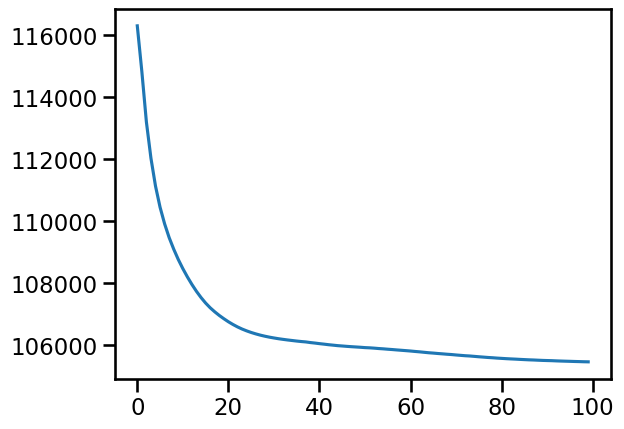

In [19]:
plt.plot(model.history['loss'])

In [20]:
model.calc_all_latent()

latent = model.get_all_latent()

In [21]:
if True:
    latent_barcode = np.array([_.split('~')[1] for _ in latent[1]])
    df_latent = pd.DataFrame(latent[0], index=latent_barcode)
    df_latent.to_csv('./outputs/ME_RNA+ATAC/res.csv')

else:
    df_latent = pd.read_csv('./outputs/ME_RNA+ATAC/res.csv', index_col=0)
    df_latent.index = df_latent.index.astype('str')

In [22]:
ad_mult_rna.obsm['X_emb'] = df_latent.loc[ad_mult_rna.obs_names, :].values
ad_atac11.obsm['X_emb'] = df_latent.loc[ad_atac11.obs_names, :].values
ad_atac13.obsm['X_emb'] = df_latent.loc[ad_atac13.obs_names, :].values
ad_atac13_2.obsm['X_emb'] = df_latent.loc[ad_atac13_2.obs_names, :].values

In [23]:
ad_mosaic = sc.concat([ad_mult_rna, ad_atac11, ad_atac13, ad_atac13_2])
ad_mosaic = get_umap(ad_mosaic, ['X_emb'])

# try:
    
#     # from sklearn.cluster import KMeans
#     # print("mclust failed, try kmeans")
#     # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['X_emb'])
#     # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     # clust_key = 'kmeans'

#     ad_mosaic = mclust_R(ad_mosaic, 10, used_obsm='X_emb')  
#     clust_key = 'mclust'
    
# except:

#     from sklearn.cluster import KMeans
#     print("mclust failed, try kmeans")
#     kmeans = KMeans(n_clusters=10, random_state=0).fit(ad_mosaic.obsm['X_emb'])
#     ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
#     clust_key = 'kmeans'

#     # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='X_emb')  
#     # clust_key = 'mclust'

# ad_mosaic.obs[clust_key] = ad_mosaic.obs[clust_key].astype('str')
# split_ob([ad_bridge_rna, ad_test_rna, ad_test_atac], ad_mosaic, ob='obs', key=clust_key)

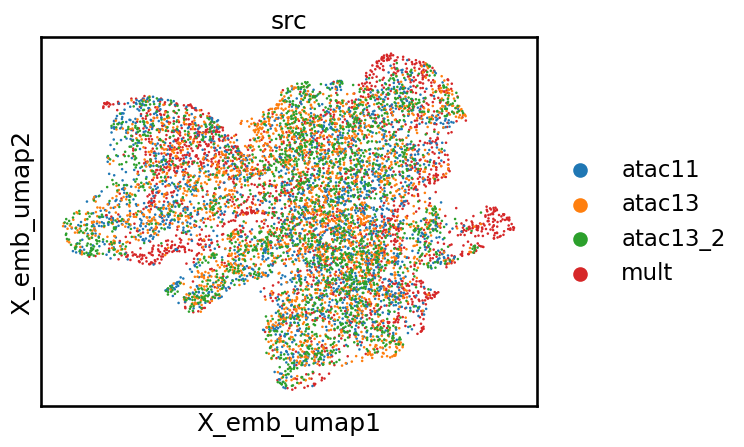

In [24]:
# # plot
wrap_warn_plot(ad_mosaic, 'X_emb_umap', ['src'])

In [28]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='X_emb', use_neighbors=False,
)
lisi_res['src_iLISI'][0]

0.662614318773882

### batch corr

In [29]:
from batchCorr import HARMONY

ad_mosaic.obsm['X_emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['X_emb']), ad_mosaic.obs['src'].to_list())
ad_mosaic = get_umap(ad_mosaic, ['X_emb_har'])
# split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obsm', key='X_emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [32]:
# r1 = eval_ads([ad_mosaic, ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', clust_key)
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='X_emb_har', use_neighbors=False,
)
r2 = lisi_res['src_iLISI'][0]

In [33]:
r2

0.7476164210937125

### Vis

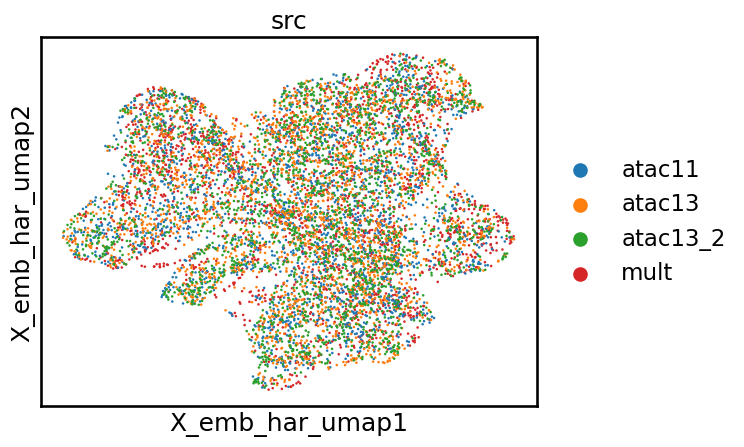

In [34]:
wrap_warn_plot(ad_mosaic, 'X_emb_har_umap', ['src'])

# unify type colors
# mclust_type2dict = dict(zip(ad_mosaic.obs.mclust.cat.categories, ad_mosaic.uns['mclust_colors']))
# label_type2dict = dict(zip(ad_mosaic.obs.Combined_Clusters_annotation.cat.categories, ad_mosaic.uns['Combined_Clusters_annotation_colors']))
# ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
#     [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'mclust', mclust_type2dict)
# ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
#     [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', label_type2dict)

In [35]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/ME_RNA+ATAC/cobolt'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['X_emb_har'], index=ad_mosaic.obs_names)
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))